In [1]:
from lxml import etree
import os
from os import listdir
import pandas as pd
from IPython.display import display, HTML
from msgspec.json import decode

from torchvision.io import read_image
import matplotlib.pyplot as plt

In [2]:
class Defect:
    assemblyRevision = ''
    serialNumber = ''
    testerName = ''
    type = ''
    dataFolderName = ''
    indictmentType = ''
    repairOperator = ''
    repairStatus = ''
    designator = ''
    partId = ''
    pinId = ''

    def to_dict(self):
        res = {}
        res['assemblyRevision'] = self.assemblyRevision
        res['serialNumber'] = self.serialNumber
        res['testerName'] = self.testerName
        res['type'] = self.type
        res['dataFolderName'] = self.dataFolderName
        res['indictmentType'] = self.indictmentType
        res['repairOperator'] = self.repairOperator
        res['repairStatus'] = self.repairStatus
        res['designator'] = self.designator
        res['partId'] = self.partId
        res['pinId'] = self.pinId

        return res

In [3]:
def parse_file_for_defects(path, include_pin = True):
    root = etree.parse(path)
    ns = root.getroot().nsmap
    res = [] #Defect()
    serialNumber = root.getroot().find("ns1:BoardXML", ns).attrib.get('serialNumber')
    testerName = root.getroot().find("ns1:StationXML", ns).attrib.get('testerName')
    assemblyRevision = root.getroot().find("ns1:BoardXML", ns).attrib.get('assemblyRevision')
    dataFolderName = root.getroot().attrib.get('dataFolderName') 

    # TestXML = root.getroot().findall(".//ns1:TestXML", ns)
    TestXML = root.getroot().findall(".//ns1:TestXML", ns)
    for test in TestXML:
        name = test.attrib.get('name')
        IndictmentXML = test.findall(".//ns1:IndictmentXML", ns)
        PinXML = test.findall(".//ns1:PinXML", ns)
    
        for Indictment in IndictmentXML:
            tmp = Defect()
            tmp.assemblyRevision = assemblyRevision
            tmp.serialNumber = serialNumber
            tmp.testerName = testerName
            tmp.designator = name
            tmp.dataFolderName = dataFolderName
            tmp.type = 'IndictmentXML'
            tmp.indictmentType = Indictment.attrib.get('indictmentType')
            tmp.repairOperator = Indictment.find("ns1:RepairActionXML", ns).attrib.get('repairOperator')
            tmp.repairStatus = Indictment.find("ns1:RepairActionXML", ns).attrib.get('repairStatus')
            tmp.partId = Indictment.find("ns1:ComponentXML", ns).attrib.get('partId')
            res.append(tmp)

        if include_pin:
            partId = IndictmentXML[0].find("ns1:ComponentXML", ns).attrib.get('partId')
            repairOperator = IndictmentXML[0].find("ns1:RepairActionXML", ns).attrib.get('repairOperator')
            for pin in PinXML:
                repairStatus = pin.attrib.get('repairStatus')
                id = pin.attrib.get('id')
                PinIndictmentXML = pin.findall(".//ns1:PinIndictmentXML", ns)
                tmp.dataFolderName = dataFolderName

                for pinIndictment in PinIndictmentXML:
                    tmp = Defect()
                    tmp.assemblyRevision = assemblyRevision
                    tmp.serialNumber = serialNumber
                    tmp.testerName = testerName
                    tmp.designator = name
                    tmp.dataFolderName = dataFolderName
                    tmp.type = 'PinXML'
                    tmp.indictmentType = pinIndictment.attrib.get('indictmentType')
                    tmp.repairOperator = repairOperator
                    tmp.repairStatus = repairStatus
                    tmp.partId = partId
                    tmp.pinId = id
                    res.append(tmp)
        
    return res

In [4]:
def get_dataFolderName(path):
    root = etree.parse(path)
    dataFolderName = root.getroot().attrib.get('dataFolderName')
    return dataFolderName


def get_df_defects(file_path, include_pin):
    defects = []
    tmp = parse_file_for_defects(file_path, include_pin = include_pin)
    for t in tmp:
        defects.append(t.to_dict())

    df_defects = pd.DataFrame(defects)

    return df_defects


def get_img_df(img_folder):
    path_json = img_folder + 'json_data.json'

    with open(path_json, "rb") as f:
        data = decode(f.read())

    all_rows = data['post_ticket']['call_summary']['falsecall_refdes']
    all_rows.update(data['post_ticket']['call_summary']['truecall_refdes'])

    df_js = pd.DataFrame.from_dict(all_rows, orient='index')
    df_js.reset_index(inplace=True)
    df_js.rename(columns={'index': 'designator'}, inplace=True)
    df_js['img_folder'] = img_folder
    
    return df_js

In [5]:
XML_FILES_PATH = '/media/ilya/My Passport/HSE/VKR/ML_AOI_helper/rawDATA/all-vvts-xml-marchonly/'
PATH_IMAGES = '/media/ilya/My Passport/HSE/VKR/ML_AOI_helper/rawDATA/2024.03/'

In [6]:
all_xml_files = listdir(XML_FILES_PATH)
all_xml_files_full = [XML_FILES_PATH + file for file in all_xml_files]
all_xml_files_full.sort(key=os.path.getmtime)
len(all_xml_files_full), all_xml_files_full[:5]

(2439,
 ['/media/ilya/My Passport/HSE/VKR/ML_AOI_helper/rawDATA/all-vvts-xml-marchonly/Y1MTB44B5Z05H#MBDX86742001B_T#V510#D-SMT-AOI-41#1#1709275967000#PostRepair#1709276669000.xml',
  '/media/ilya/My Passport/HSE/VKR/ML_AOI_helper/rawDATA/all-vvts-xml-marchonly/Y1MTB44B5Z04Y#MBDX86742001B_T#V510#D-SMT-AOI-41#1#1709276531000#PostRepair#1709277423000.xml',
  '/media/ilya/My Passport/HSE/VKR/ML_AOI_helper/rawDATA/all-vvts-xml-marchonly/Y1MTB44B5Z043#MBDX86742001B_T#V510#D-SMT-AOI-41#1#1709276393000#PostRepair#1709278238000.xml',
  '/media/ilya/My Passport/HSE/VKR/ML_AOI_helper/rawDATA/all-vvts-xml-marchonly/Y1MTB44B5Z05I#MBDX86742001B_T#V510#D-SMT-AOI-41#1#1709276243000#PostRepair#1709281005000.xml',
  '/media/ilya/My Passport/HSE/VKR/ML_AOI_helper/rawDATA/all-vvts-xml-marchonly/Y1MTB44BYF0BA#MBDX86742001B_T#V510#D-SMT-AOI-41#1#1709281218000#PostRepair#1709282671000.xml'])

In [7]:
valid_xml_files = []
nones = 0

for file in all_xml_files_full:
    tmp = get_dataFolderName(file)
    if tmp != None:
        # print(tmp, PATH_IMAGES + tmp.split('-')[-4] + '/' + tmp + '/json_data.json')
        if os.path.isfile(PATH_IMAGES + tmp.split('-')[-4] + '/' + tmp + '/json_data.json'):
            valid_xml_files.append(file)
    else:
        nones += 1
    
len(valid_xml_files), nones, nones*100/len(valid_xml_files), nones + len(valid_xml_files)

(2149, 261, 12.145183806421592, 2410)

In [8]:
valid_xml_files[:3]

['/media/ilya/My Passport/HSE/VKR/ML_AOI_helper/rawDATA/all-vvts-xml-marchonly/Y1MTB44B5Z05H#MBDX86742001B_T#V510#D-SMT-AOI-41#1#1709275967000#PostRepair#1709276669000.xml',
 '/media/ilya/My Passport/HSE/VKR/ML_AOI_helper/rawDATA/all-vvts-xml-marchonly/Y1MTB44B5Z04Y#MBDX86742001B_T#V510#D-SMT-AOI-41#1#1709276531000#PostRepair#1709277423000.xml',
 '/media/ilya/My Passport/HSE/VKR/ML_AOI_helper/rawDATA/all-vvts-xml-marchonly/Y1MTB44B5Z043#MBDX86742001B_T#V510#D-SMT-AOI-41#1#1709276393000#PostRepair#1709278238000.xml']

In [9]:
list_df = []

for file_path in valid_xml_files:
    df_defects_tmp = get_df_defects(file_path, False)
    tmp = get_dataFolderName(file_path)
    df_img_tmp = get_img_df(PATH_IMAGES + tmp.split('-')[-4] + '/' + tmp + '/')
    df_total = df_defects_tmp.merge(df_img_tmp, on='designator', how='inner')
    list_df.append(df_total)

df_total_pre = pd.concat(list_df)
df_total_pre.describe()

,assemblyRevision,serialNumber,testerName,type,dataFolderName,indictmentType,repairOperator,repairStatus,designator,partId,pinId,defect_name,defect_image,img_folder
count,65488,65488,65488,65488,65488,65488,65488,65488,65488,65488,65488,65488,65488,65488
unique,12,1593,3,1,2148,22,7,2,2020,253,1,178,55521,2148
top,MPLSAS731005D_T,Y1MTB449MV001,D-SMT-AOI-41,IndictmentXML,D-SMT-AOI-41[@$@]2024-03-12-22-05-12,BadJoint,Larisa_VVTS08,False Call,j87,0787280002,,[BadJoint],noImage,/media/ilya/My Passport/HSE/VKR/ML_AOI_helper/...
freq,33925,485,52427,65488,288,30643,34110,65020,858,24192,65488,27127,12,288


In [10]:
df_total_pre.loc[df_total_pre.repairStatus == 'False Call', 'repairStatus'] = 1
df_total_pre.loc[df_total_pre.repairStatus == 'Repaired', 'repairStatus'] = 0
df_total_pre.head()

,assemblyRevision,serialNumber,testerName,type,dataFolderName,indictmentType,repairOperator,repairStatus,designator,partId,pinId,defect_name,defect_image,img_folder
0,MBDX86742001B_T,Y1MTB44B5Z05H,D-SMT-AOI-41,IndictmentXML,D-SMT-AOI-41[@$@]2024-03-01-09-53-26,OCV Fail,Svetlana_VVTS08,1,1:q68,BSC0906NSATMA1,,[OCV Fail],E_4509_1-q68.jpg,/media/ilya/My Passport/HSE/VKR/ML_AOI_helper/...
1,MBDX86742001B_T,Y1MTB44B5Z05H,D-SMT-AOI-41,IndictmentXML,D-SMT-AOI-41[@$@]2024-03-01-09-53-26,OCV Fail,Svetlana_VVTS08,1,1:q67,BSC0906NSATMA1,,[OCV Fail],E_4509_1-q67.jpg,/media/ilya/My Passport/HSE/VKR/ML_AOI_helper/...
2,MBDX86742001B_T,Y1MTB44B5Z05H,D-SMT-AOI-41,IndictmentXML,D-SMT-AOI-41[@$@]2024-03-01-09-53-26,Bridging,Svetlana_VVTS08,1,1:u139,TPS62130ARGTT,,[Bridging],E_4509_1-u139.jpg,/media/ilya/My Passport/HSE/VKR/ML_AOI_helper/...
3,MBDX86742001B_T,Y1MTB44B5Z05H,D-SMT-AOI-41,IndictmentXML,D-SMT-AOI-41[@$@]2024-03-01-09-53-26,Bridging,Svetlana_VVTS08,1,1:y1,ABM8G-48_000MHZ-4Y-T3,,[Bridging],E_4509_1-y1.jpg,/media/ilya/My Passport/HSE/VKR/ML_AOI_helper/...
4,MBDX86742001B_T,Y1MTB44B5Z05H,D-SMT-AOI-41,IndictmentXML,D-SMT-AOI-41[@$@]2024-03-01-09-53-26,Extra Part,Svetlana_VVTS08,1,1:u9,SN74LVC1G17DCKR,,[Extra Part],E_4509_1-u9.jpg,/media/ilya/My Passport/HSE/VKR/ML_AOI_helper/...


In [11]:
df_total_pre['defect_image'].value_counts()

defect_image
noImage              12
E_4869_1-u283.jpg     7
E_4837_1-u163.jpg     7
E_031_r314.jpg        6
E_4665_1-u151.jpg     6
                     ..
E_386_j27.jpg         1
E_386_j16.jpg         1
E_386_j19.jpg         1
E_386_j22.jpg         1
E_4505_1-u133.jpg     1
Name: count, Length: 55521, dtype: int64

In [12]:
df_total_pre = df_total_pre[df_total_pre.defect_image != 'noImage']
df_total_pre.describe()

,assemblyRevision,serialNumber,testerName,type,dataFolderName,indictmentType,repairOperator,repairStatus,designator,partId,pinId,defect_name,defect_image,img_folder
count,65476,65476,65476,65476,65476,65476,65476,65476,65476,65476,65476,65476,65476,65476
unique,12,1593,3,1,2148,22,7,2,2018,252,1,178,55520,2148
top,MPLSAS731005D_T,Y1MTB449MV001,D-SMT-AOI-41,IndictmentXML,D-SMT-AOI-41[@$@]2024-03-12-22-05-12,BadJoint,Larisa_VVTS08,1,j87,0787280002,,[BadJoint],E_4837_1-u163.jpg,/media/ilya/My Passport/HSE/VKR/ML_AOI_helper/...
freq,33925,485,52427,65476,288,30631,34110,65008,858,24192,65476,27115,7,288


In [2]:
df_total_pre.to_csv('df_total_pre.csv', index=False)

NameError: name 'df_total_pre' is not defined

In [5]:
df_total_pre = pd.read_csv('df_total_pre.csv')
df_total_pre.head()

,assemblyRevision,serialNumber,testerName,type,dataFolderName,indictmentType,repairOperator,repairStatus,designator,partId,pinId,defect_name,defect_image,img_folder
0,MBDX86742001B_T,Y1MTB44B5Z05H,D-SMT-AOI-41,IndictmentXML,D-SMT-AOI-41[@$@]2024-03-01-09-53-26,OCV Fail,Svetlana_VVTS08,1,1:q68,BSC0906NSATMA1,NaN,['OCV Fail'],E_4509_1-q68.jpg,/media/ilya/My Passport/HSE/VKR/ML_AOI_helper/...
1,MBDX86742001B_T,Y1MTB44B5Z05H,D-SMT-AOI-41,IndictmentXML,D-SMT-AOI-41[@$@]2024-03-01-09-53-26,OCV Fail,Svetlana_VVTS08,1,1:q67,BSC0906NSATMA1,NaN,['OCV Fail'],E_4509_1-q67.jpg,/media/ilya/My Passport/HSE/VKR/ML_AOI_helper/...
2,MBDX86742001B_T,Y1MTB44B5Z05H,D-SMT-AOI-41,IndictmentXML,D-SMT-AOI-41[@$@]2024-03-01-09-53-26,Bridging,Svetlana_VVTS08,1,1:u139,TPS62130ARGTT,NaN,['Bridging'],E_4509_1-u139.jpg,/media/ilya/My Passport/HSE/VKR/ML_AOI_helper/...
3,MBDX86742001B_T,Y1MTB44B5Z05H,D-SMT-AOI-41,IndictmentXML,D-SMT-AOI-41[@$@]2024-03-01-09-53-26,Bridging,Svetlana_VVTS08,1,1:y1,ABM8G-48_000MHZ-4Y-T3,NaN,['Bridging'],E_4509_1-y1.jpg,/media/ilya/My Passport/HSE/VKR/ML_AOI_helper/...
4,MBDX86742001B_T,Y1MTB44B5Z05H,D-SMT-AOI-41,IndictmentXML,D-SMT-AOI-41[@$@]2024-03-01-09-53-26,Extra Part,Svetlana_VVTS08,1,1:u9,SN74LVC1G17DCKR,NaN,['Extra Part'],E_4509_1-u9.jpg,/media/ilya/My Passport/HSE/VKR/ML_AOI_helper/...


In [4]:
i = 55555
img_path = df_total_pre.iloc[i]['img_folder'] + df_total_pre.iloc[i]['defect_image']

img = read_image(img_path)
plt.imshow(  img.permute(1, 2, 0)  )

RuntimeError: [Errno 2] No such file or directory: '/media/ilya/My Passport/HSE/VKR/ML_AOI_helper/rawDATA/2024.03/13/D-SMT-AOI-41[@$@]2024-03-13-16-15-29/E_1862_u6.jpg'

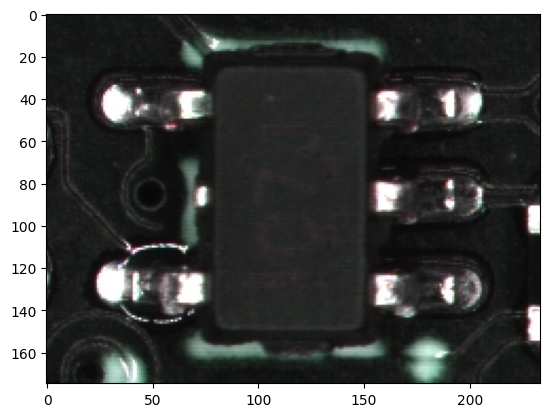

In [15]:
i = 555
img_path = df_total_pre.iloc[i]['img_folder'] + df_total_pre.iloc[i]['defect_image']

img = read_image(img_path)
plt.imshow(  img.permute(1, 2, 0)  )

In [16]:
df_total_false = df_total_pre.loc[df_total_pre['repairStatus'] == 1]
df_total_false.describe()

,assemblyRevision,serialNumber,testerName,type,dataFolderName,indictmentType,repairOperator,repairStatus,designator,partId,pinId,defect_name,defect_image,img_folder
count,65008,65008,65008,65008,65008,65008,65008,65008,65008,65008,65008,65008,65008,65008
unique,12,1593,3,1,2146,19,7,1,1944,248,1,174,55053,2146
top,MPLSAS731005D_T,Y1MTB449MV001,D-SMT-AOI-41,IndictmentXML,D-SMT-AOI-41[@$@]2024-03-12-22-05-12,BadJoint,Larisa_VVTS08,1,j87,0787280002,,[BadJoint],E_4837_1-u163.jpg,/media/ilya/My Passport/HSE/VKR/ML_AOI_helper/...
freq,33695,485,52102,65008,287,30572,33930,65008,830,24188,65008,27057,7,287


In [17]:
65008 * 0.1 + 65008 * 0.75, 65008 * 0.75

(55256.8, 48756.0)

In [18]:
df_total_false_train = df_total_false[:48756]
df_total_false_val = df_total_false[48757:55257]
df_total_false_test = df_total_false[55258:]

In [19]:
df_total_true = df_total_pre.loc[df_total_pre['repairStatus'] == 0]
df_total_true.describe()

,assemblyRevision,serialNumber,testerName,type,dataFolderName,indictmentType,repairOperator,repairStatus,designator,partId,pinId,defect_name,defect_image,img_folder
count,468,468,468,468,468,468,468,468,468,468,468,468,468,468
unique,9,322,3,1,334,15,7,1,205,61,1,15,467,334
top,MPLSAS731005D_T,Y1F1D444W722H,D-SMT-AOI-41,IndictmentXML,D-SMT-AOI-41[@$@]2024-03-12-13-11-47,Skew,Larisa_VVTS08,0,j84,MEC1-108-02-L-D-RA1-SL,,[Skew],E_1794_j85.jpg,/media/ilya/My Passport/HSE/VKR/ML_AOI_helper/...
freq,230,12,325,468,8,107,180,468,37,103,468,107,2,8


In [20]:
468 * 0.1 + 468 * 0.75, 468 * 0.75

(397.8, 351.0)

In [26]:
df_total_true_train = df_total_true[:350]
df_total_true_val = df_total_true[351:397]
df_total_true_test = df_total_true[398:]

In [55]:
df_total_train = pd.concat([df_total_false_train, df_total_true_train])
df_total_val = pd.concat([df_total_false_val, df_total_true_val])
df_total_test = pd.concat([df_total_false_test, df_total_true_test])

df_total_train.to_csv('df_total_train.csv', index=False)
df_total_val.to_csv('df_total_val.csv', index=False)
df_total_test.to_csv('df_total_test.csv', index=False)

In [23]:
indictmentType = df_total_true['indictmentType'].value_counts()
indictmentType

indictmentType
Skew            107
Missing          69
Lifted lead      66
BadJoint         59
RowOffset        37
Coplanarity      37
Extra Part       37
Bridging         25
Tombstone        18
Flipped           4
Missing lead      3
Left off          2
Damaged           2
XS paste          1
Lifted Lead       1
Name: count, dtype: int64

In [28]:
df_total_false['indictmentType'].value_counts()

indictmentType
BadJoint           30572
Coplanarity         8283
OCV Fail            5691
Bridging            4666
RowOffset           3485
Polarity            2884
Lifted Lead         2495
Missing Lead        1254
Hor off             1101
Extra Part          1066
Billboard           1063
Left off             736
Right off            709
Missing              660
Skew                 214
Side Camera Err       64
Flipped               57
Damaged                7
XS paste               1
Name: count, dtype: int64

In [27]:
df_total_true_test['indictmentType'].value_counts()

indictmentType
Coplanarity    24
BadJoint       14
Extra Part     11
Lifted lead     8
Skew            5
Tombstone       3
RowOffset       3
Missing         1
Flipped         1
Name: count, dtype: int64

In [6]:
df_total_false = df_total_pre.loc[df_total_pre['repairStatus'] == 1].sample(frac=1)

df_total_false_train = df_total_false[:48756]
df_total_false_val = df_total_false[48757:55257]
df_total_false_test = df_total_false[55258:]

df_total_false.head()

,assemblyRevision,serialNumber,testerName,type,dataFolderName,indictmentType,repairOperator,repairStatus,designator,partId,pinId,defect_name,defect_image,img_folder
46944,MPLSAS731005D_T,Y0PYD449MV013,D-SMT-AOI-41,IndictmentXML,D-SMT-AOI-41[@$@]2024-03-12-22-01-53,RowOffset,Larisa_VVTS08,1,j87,MEC1-108-02-L-D-RA1-SL,NaN,"['BadJoint', 'RowOffset', 'Lifted Lead']",E_1671_j87.jpg,/media/ilya/My Passport/HSE/VKR/ML_AOI_helper/...
47648,IOBBUT781001D_T,Y1F1D4443R029,D-SMT-AOI-11,IndictmentXML,D-SMT-AOI-11[@$@]2024-03-12-22-27-10,BadJoint,Mihail_V,1,28:u1,SN74LVC541ARGYR,NaN,['BadJoint'],E_2972_28-u1.jpg,/media/ilya/My Passport/HSE/VKR/ML_AOI_helper/...
22715,MBDX86691004A_T,Y2G9A44ADJ001,D-SMT-AOI-51,IndictmentXML,D-SMT-AOI-51[@$@]2024-03-05-23-17-28,Bridging,Oleg_VVTS08,1,1:qp270,07_02_42_010201-527,NaN,['Bridging'],E_861_1-qp270.jpg,/media/ilya/My Passport/HSE/VKR/ML_AOI_helper/...
56529,MPLSAS731005D_T,Y0PYD445ON02N,D-SMT-AOI-41,IndictmentXML,D-SMT-AOI-41[@$@]2024-03-13-16-56-13,Lifted Lead,Larisa_VVTS08,1,j33,0787280002,NaN,"['Lifted Lead', 'Coplanarity', 'Missing Lead']",E_1875_j33.jpg,/media/ilya/My Passport/HSE/VKR/ML_AOI_helper/...
21390,MPLSAS731005D_T,Y0PYD443BB002,D-SMT-AOI-41,IndictmentXML,D-SMT-AOI-41[@$@]2024-03-05-15-14-02,BadJoint,Larisa_VVTS08,1,j52,0787280002,NaN,['BadJoint'],E_043_j52.jpg,/media/ilya/My Passport/HSE/VKR/ML_AOI_helper/...


In [7]:
df_total_true = df_total_pre.loc[df_total_pre['repairStatus'] == 0].sample(frac=1)

df_total_true_train = df_total_true[:350]
df_total_true_val = df_total_true[351:397]
df_total_true_test = df_total_true[398:]

df_total_true.head()

,assemblyRevision,serialNumber,testerName,type,dataFolderName,indictmentType,repairOperator,repairStatus,designator,partId,pinId,defect_name,defect_image,img_folder
33775,MPLSAS731005D_T,Y0PYD445ON008,D-SMT-AOI-41,IndictmentXML,D-SMT-AOI-41[@$@]2024-03-11-22-32-29,Skew,Mihail_V,0,d48,APHB1608ZGSURKC,NaN,['Skew'],E_1268_d48.jpg,/media/ilya/My Passport/HSE/VKR/ML_AOI_helper/...
38768,MPLSAS731005D_T,Y0PYD448UF00G,D-SMT-AOI-41,IndictmentXML,D-SMT-AOI-41[@$@]2024-03-12-13-11-47,Missing,Evgeniy_M,0,r304,RC0402JR-07300RL,NaN,['Missing'],E_1387_r304.jpg,/media/ilya/My Passport/HSE/VKR/ML_AOI_helper/...
36786,MPLSAS731005D_T,Y0PYD448UF05K,D-SMT-AOI-41,IndictmentXML,D-SMT-AOI-41[@$@]2024-03-12-10-39-39,Lifted lead,Natasha_VVTS08,0,j87,MEC1-108-02-L-D-RA1-SL,NaN,['Lifted lead'],E_1343_j87.jpg,/media/ilya/My Passport/HSE/VKR/ML_AOI_helper/...
60087,IOBBUT781001D_T,Y1F1D444W722H,D-SMT-AOI-11,IndictmentXML,D-SMT-AOI-11[@$@]2024-03-13-19-32-28,Extra Part,Mihail_V,0,7:s3,EVQP7C01P,NaN,['Extra Part'],E_3117_7-s3.jpg,/media/ilya/My Passport/HSE/VKR/ML_AOI_helper/...
60370,IOBBUT781001D_T,Y1F1D444W722H,D-SMT-AOI-11,IndictmentXML,D-SMT-AOI-11[@$@]2024-03-13-19-54-45,Extra Part,Mihail_V,0,7:u2,SN74LVC541ARGYR,NaN,['Extra Part'],E_3120_7-u2.jpg,/media/ilya/My Passport/HSE/VKR/ML_AOI_helper/...


In [15]:
df_total_train = pd.concat([df_total_false_train, df_total_true_train])
df_total_val = pd.concat([df_total_false_val, df_total_true_val])
df_total_test = pd.concat([df_total_false_test, df_total_true_test])

df_total_train.to_csv('df_total_train_shuffled_v1.csv', index=False)
df_total_val.to_csv('df_total_val_shuffled_v1.csv', index=False)
df_total_test.to_csv('df_total_test_shuffled_v1.csv', index=False)

In [13]:
df_total_true_train['indictmentType'].value_counts(), df_total_true_val['indictmentType'].value_counts()

(indictmentType
 Skew            79
 Lifted lead     52
 Missing         50
 BadJoint        41
 Extra Part      34
 RowOffset       31
 Coplanarity     26
 Bridging        19
 Tombstone       11
 Missing lead     2
 Damaged          2
 Flipped          2
 XS paste         1
 Name: count, dtype: int64,
 indictmentType
 Skew           14
 BadJoint        8
 Missing         5
 RowOffset       5
 Lifted lead     4
 Coplanarity     3
 Extra Part      2
 Bridging        2
 Tombstone       2
 Flipped         1
 Name: count, dtype: int64)

In [14]:
df_total_true_test['indictmentType'].value_counts()

indictmentType
Missing         14
Skew            14
Lifted lead     10
BadJoint         9
Coplanarity      7
Tombstone        5
Bridging         4
Left off         2
Extra Part       1
Missing lead     1
RowOffset        1
Lifted Lead      1
Flipped          1
Name: count, dtype: int64